In [246]:
import os
import json
import warnings
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

os.makedirs('./plots_html/', exist_ok=True)
os.makedirs('./plots_png/', exist_ok=True)
os.makedirs('./preprocessed_data/', exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# GLOBALS
BATCH_FILES = 42
UNLABELED_FULL_DATASET = 'no_dups_25K_70_Domains_n5_with_ratings_find_more_enegs.csv'

# Define correct labels
LABELS = (
    "Extremely Negative (ENEG)",
    "Negative (NEG)",
    "Slightly Negative (SNEG)",
    "Neutral (NEU)",
    "Slightly Positive (SPOS)",
    "Positive (POS)",
)

# TODO: Which score should be used for the sentiment analysis?
# SENTIMENT_SCORES = {
#     "Extremely Negative (ENEG)": -2,
#     "Negative (NEG)": -1,
#     "Slightly Negative (SNEG)": -0.5,
#     "Neutral (NEU)": 0,
#     "Slightly Positive (SPOS)": 1,
#     "Positive (POS)": 2,
# }

SENTIMENT_SCORES = {
    "Extremely Negative (ENEG)": -3,
    "Negative (NEG)": -2,
    "Slightly Negative (SNEG)": -1,
    "Neutral (NEU)": 0,
    "Slightly Positive (SPOS)": 1,
    "Positive (POS)": 2,
}


## 1. Read Data

In [247]:
full_dataset = pd.read_csv(f'./final_data/{UNLABELED_FULL_DATASET}')

print("Dataset columns:", full_dataset.columns)

Dataset columns: Index(['Domain', 'URL', 'Title', 'MainText', 'date', 'relevancy', 'Rating',
       'Uncertainty'],
      dtype='object')


Now we want to go over all the batches, the OpenAI responses, and combine them together. each batch contains labeling for the articles sent in the batch. We will also validate each article in a batch has a label and the are no inconsistencies.

In [248]:
# Initialize lists
batch_data = []
responses = []

# Load the batch JSONL file and extract custom_ids from the articles we sent for labeling
batch_custom_ids = []
for i in range(1, BATCH_FILES):
    batch_file_path = f'./final_data/Batch{i}/batch_{i}.jsonl'
    if os.path.exists(batch_file_path):
        with open(batch_file_path, 'r') as f:
            for line in f:
                data = json.loads(line)
                custom_id = data['custom_id']
                batch_custom_ids.append(custom_id)
                batch_data.append(data)

# Load the response JSONL files and extract custom_ids from the responses
response_custom_ids = []
for i in range(1, BATCH_FILES):
    batch_folder_path = f'./final_data/Batch{i}'
    for filename in os.listdir(batch_folder_path):
        if '_output' in filename and filename.endswith('.jsonl'):
            file_path = os.path.join(batch_folder_path, filename)
            with open(file_path, 'r') as f:
                for line in f:
                    response_data = json.loads(line)
                    custom_id = response_data['custom_id']
                    response_custom_ids.append(custom_id)
                    responses.append(response_data)

# Compare custom_ids
missing_responses = set(batch_custom_ids) - set(response_custom_ids)
extra_responses = set(response_custom_ids) - set(batch_custom_ids)

# Output missing and extra responses
if missing_responses:
    print(f"Missing responses for {len(missing_responses)} custom_ids:")
    print(missing_responses)
else:
    print("No missing responses.")

if extra_responses:
    print(f"Extra responses for {len(extra_responses)} custom_ids:")
    print(extra_responses)
else:
    print("No extra responses.")

# Extract predictions from response JSONL files
predictions = []
for response in responses:
    custom_id = response['custom_id']
    try:
        label = response['response']['body']['choices'][0]['message']['content'].split(': ')[1].strip()
    except IndexError as e:
        print(f"Error processing response with custom_id {custom_id}: {e}")
        label = "Error extracting label"
    predictions.append(label)

# Output some predictions for verification
print("Sample predictions:", predictions[:10])

No missing responses.
No extra responses.
Sample predictions: ['Neutral (NEU)', 'Neutral (NEU)', 'Neutral (NEU)', 'Neutral (NEU)', 'Neutral (NEU)', 'Slightly Negative (SNEG)', 'Slightly Negative (SNEG)', 'Neutral (NEU)', 'Neutral (NEU)', 'Slightly Negative (SNEG)']


Now we need to merge the predictions back into the full dataset

In [249]:
full_dataset['label'] = None

for i in range(min(len(predictions), len(full_dataset))):
    full_dataset.at[i, 'label'] = predictions[i]

full_dataset.to_csv('./preprocessed_data/articles_with_predictions_1.csv', index=False)
print("CSV file 'articles_with_predictions_1.csv' created successfully.")

CSV file 'articles_with_predictions_1.csv' created successfully.


## 2. Clean Incorrect Labels 

In [250]:
# print labels distribution. Some labels are tagged incorrectly
print("Labels distribution:")
print(full_dataset['label'].value_counts())

Labels distribution:
label
Slightly Negative (SNEG)             8884
Neutral (NEU)                        5735
Positive (POS)                       3933
Negative (NEG)                       3161
Slightly Positive (SPOS)             1517
Extremely Negative (ENEG)            1250
Slightly Neutral (SNEU)                 2
Irrelevant Content (IRR)                1
Slight Negative (SNEG)                  1
Mixed Sentiment                         1
Slightly Slightly Negative (SNEG)       1
Mixed-Slightly Positive (SPOS)          1
Name: count, dtype: int64


In [251]:
# Rename incorrect or similar labels
label_mapping = {
    "Irrelevant Content (IRR)": "Neutral (NEU)",
    "Slightly Neutral (SNEU)": "Neutral (NEU)",
    "Slight Negative (SNEG)": "Slightly Negative (SNEG)",
    "Slightly Slightly Negative (SNEG)": "Slightly Negative (SNEG)",
    "Mixed Sentiment": "Neutral (NEU)"
}

# Clean labels
def clean_label(label):
    if label in label_mapping:
        return label_mapping[label]
    elif label in LABELS:
        return label
    return "Neutral (NEU)"

# Apply cleaning to the new labels
full_dataset['label'] = full_dataset['label'].apply(clean_label)

# Remove rows with incorrect labels if any exist
if full_dataset['label'].isnull().sum() > 0:
    full_dataset = full_dataset.dropna(subset=['label'])

# Count the occurrences of each correct label for verification
label_counts = full_dataset['label'].value_counts().reindex(LABELS, fill_value=0)
print("Cleaned Label Counts:")
print(label_counts)

# Save the cleaned DataFrame to a CSV file
full_dataset.to_csv('./preprocessed_data/articles_with_predictions_2.csv', index=False)
print("Cleaned data saved to 'articles_with_predictions_2.csv'.")

Cleaned Label Counts:
label
Extremely Negative (ENEG)    1250
Negative (NEG)               3161
Slightly Negative (SNEG)     8886
Neutral (NEU)                6289
Slightly Positive (SPOS)     1517
Positive (POS)               3933
Name: count, dtype: int64
Cleaned data saved to 'articles_with_predictions_2.csv'.


In [252]:
# Parse the date column to datetime format
full_dataset['date'] = pd.to_datetime(full_dataset['date'])

# Assign sentiment scores to the labels
full_dataset['sentiment_score'] = full_dataset['label'].map(SENTIMENT_SCORES)

Now we can use chatGPT to help us find the country and region for each domain found in the dataset.

In [253]:
print("Domain names:")
print(full_dataset['Domain'].unique())

Domain names:
['apnews.com' 'chinadaily.com.cn' 'dw.com' 'foxnews.com'
 'hurriyetdailynews.com' 'indiatimes.com' 'irishexaminer.com'
 'irishtimes.com' 'latimes.com' 'news24.com' 'nypost.com'
 'telegraph.co.uk' 'theglobeandmail.com' 'theguardian.com'
 'thestar.com.my' 'abc.net.au' 'dailymail.co.uk' 'npr.org'
 'straitstimes.com' 'dailysabah.com' 'independent.ie' 'lemonde.fr'
 'mg.co.za' 'hindustantimes.com' 'swissinfo.ch' 'taipeitimes.com'
 'taiwannews.com.tw' 'washingtonpost.com' 'cnn.com' 'nbcnews.com'
 'thedailystar.net' 'bbc.co.uk' 'bbc.com' 'independent.co.uk' 'cbc.ca'
 'usatoday.com' 'mirror.co.uk' 'scmp.com' 'huffpost.com'
 'thejakartapost.com' 'aljazeera.com' 'thesouthafrican.com' '9news.com.au'
 'herald.co.zw' 'hollywoodreporter.com' 'mexiconewsdaily.com'
 'themoscowtimes.com' 'reuters.com' 'thesun.co.uk' 'kyivpost.com'
 'bangkokpost.com' 'japantimes.co.jp' 'timesnownews.com'
 'riviera-maya-news.com' 'the-sun.com' 'wsj.com' 'connexionfrance.com'
 'snl24.com' 'nytimes.com' 'spieg

In [254]:
# Define a mapping of domains to specific countries
domain_to_country = {
    'apnews.com': 'United States',
    'chinadaily.com.cn': 'China',
    'dw.com': 'Germany',
    'foxnews.com': 'United States',
    'hurriyetdailynews.com': 'Turkey',
    'indiatimes.com': 'India',
    'irishexaminer.com': 'Ireland',
    'irishtimes.com': 'Ireland',
    'latimes.com': 'United States',
    'news24.com': 'South Africa',
    'nypost.com': 'United States',
    'telegraph.co.uk': 'United Kingdom',
    'theglobeandmail.com': 'Canada',
    'theguardian.com': 'United Kingdom',
    'thestar.com.my': 'Malaysia',
    'abc.net.au': 'Australia',
    'dailymail.co.uk': 'United Kingdom',
    'npr.org': 'United States',
    'straitstimes.com': 'Singapore',
    'dailysabah.com': 'Turkey',
    'independent.ie': 'Ireland',
    'lemonde.fr': 'France',
    'mg.co.za': 'South Africa',
    'hindustantimes.com': 'India',
    'swissinfo.ch': 'Switzerland',
    'taipeitimes.com': 'Taiwan',
    'taiwannews.com.tw': 'Taiwan',
    'washingtonpost.com': 'United States',
    'cnn.com': 'United States',
    'nbcnews.com': 'United States',
    'thedailystar.net': 'Bangladesh',
    'bbc.co.uk': 'United Kingdom',
    'bbc.com': 'United Kingdom',
    'independent.co.uk': 'United Kingdom',
    'cbc.ca': 'Canada',
    'usatoday.com': 'United States',
    'mirror.co.uk': 'United Kingdom',
    'scmp.com': 'Hong Kong',
    'huffpost.com': 'United States',
    'thejakartapost.com': 'Indonesia',
    'aljazeera.com': 'Qatar',
    'thesouthafrican.com': 'South Africa',
    '9news.com.au': 'Australia',
    'herald.co.zw': 'Zimbabwe',
    'hollywoodreporter.com': 'United States',
    'mexiconewsdaily.com': 'Mexico',
    'themoscowtimes.com': 'Russia',
    'reuters.com': 'United Kingdom',
    'thesun.co.uk': 'United Kingdom',
    'kyivpost.com': 'Ukraine',
    'bangkokpost.com': 'Thailand',
    'japantimes.co.jp': 'Japan',
    'timesnownews.com': 'India',
    'riviera-maya-news.com': 'Mexico',
    'the-sun.com': 'United States',
    'wsj.com': 'United States',
    'connexionfrance.com': 'France',
    'snl24.com': 'South Africa',
    'nytimes.com': 'United States',
    'spiegel.de': 'Germany',
    'rt.com': 'Russia',
    'grapevine.is': 'Iceland',
    'vanguardngr.com': 'Nigeria',
    'wantedinrome.com': 'Italy',
    'thelocal.se': 'Sweden'
}

# Define a mapping of domains to regions
domain_to_region = {
    'apnews.com': 'North America',
    'chinadaily.com.cn': 'Asia',
    'dw.com': 'Europe',
    'foxnews.com': 'North America',
    'hurriyetdailynews.com': 'Middle East',
    'indiatimes.com': 'Asia',
    'irishexaminer.com': 'Europe',
    'irishtimes.com': 'Europe',
    'latimes.com': 'North America',
    'news24.com': 'Africa',
    'nypost.com': 'North America',
    'telegraph.co.uk': 'Europe',
    'theglobeandmail.com': 'North America',
    'theguardian.com': 'Europe',
    'thestar.com.my': 'Asia',
    'abc.net.au': 'Oceania',
    'dailymail.co.uk': 'Europe',
    'npr.org': 'North America',
    'straitstimes.com': 'Asia',
    'dailysabah.com': 'Middle East',
    'independent.ie': 'Europe',
    'lemonde.fr': 'Europe',
    'mg.co.za': 'Africa',
    'hindustantimes.com': 'Asia',
    'swissinfo.ch': 'Europe',
    'taipeitimes.com': 'Asia',
    'taiwannews.com.tw': 'Asia',
    'washingtonpost.com': 'North America',
    'cnn.com': 'North America',
    'nbcnews.com': 'North America',
    'thedailystar.net': 'Asia',
    'bbc.co.uk': 'Europe',
    'bbc.com': 'Europe',
    'independent.co.uk': 'Europe',
    'cbc.ca': 'North America',
    'usatoday.com': 'North America',
    'mirror.co.uk': 'Europe',
    'scmp.com': 'Asia',
    'huffpost.com': 'North America',
    'thejakartapost.com': 'Asia',
    'aljazeera.com': 'Middle East',
    'thesouthafrican.com': 'Africa',
    '9news.com.au': 'Oceania',
    'herald.co.zw': 'Africa',
    'hollywoodreporter.com': 'North America',
    'mexiconewsdaily.com': 'North America',
    'themoscowtimes.com': 'Europe',
    'reuters.com': 'Europe',
    'thesun.co.uk': 'Europe',
    'kyivpost.com': 'Europe',
    'bangkokpost.com': 'Asia',
    'japantimes.co.jp': 'Asia',
    'timesnownews.com': 'Asia',
    'riviera-maya-news.com': 'North America',
    'the-sun.com': 'North America',
    'wsj.com': 'North America',
    'connexionfrance.com': 'Europe',
    'snl24.com': 'Africa',
    'nytimes.com': 'North America',
    'spiegel.de': 'Europe',
    'rt.com': 'Europe',
    'grapevine.is': 'Europe',
    'vanguardngr.com': 'Africa',
    'wantedinrome.com': 'Europe',
    'thelocal.se': 'Europe'
}

full_dataset['Country'] = full_dataset['Domain'].map(domain_to_country)
full_dataset['Region'] = full_dataset['Domain'].map(domain_to_region)

print(full_dataset[['Domain', 'Country', 'Region']].head(10).drop_duplicates())

full_dataset.to_csv('./preprocessed_data/articles_with_predictions_3.csv', index=False)
print("CSV file 'articles_with_predictions_3.csv' created successfully.")

                  Domain        Country         Region
0             apnews.com  United States  North America
2      chinadaily.com.cn          China           Asia
4                 dw.com        Germany         Europe
5            foxnews.com  United States  North America
8  hurriyetdailynews.com         Turkey    Middle East
9         indiatimes.com          India           Asia
CSV file 'articles_with_predictions_3.csv' created successfully.


## 3. Play with the labeled data & Plots

## Sentiment Analysis Overview

In [255]:
# Load the CSV file
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

In [256]:
# Count the number of articles with each label
label_counts = df['label'].value_counts().reindex(LABELS, fill_value=0).reset_index()
label_counts.columns = ['Sentiment', 'Count']

plt.figure(figsize=(16, 12))

fig = px.bar(
    label_counts,
    x='Sentiment',
    y='Count',
    color='Sentiment',
    color_discrete_sequence=px.colors.sequential.Viridis,
    title='Distribution of Article Sentiments',
    labels={'Count': 'Number of Articles'}
)

fig.update_traces(texttemplate='%{y}', textposition='outside')
fig.update_layout(
    xaxis_title='Sentiment Labels',
    yaxis_title='Number of Articles',
    title_font_size=20,
    xaxis_tickangle=-45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        range=[0, label_counts['Count'].max() + 1500],
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig.show()
fig.write_html('./plots_html/article_sentiment_distribution_interactive.html')

<Figure size 1600x1200 with 0 Axes>

In [257]:
# Group by date and calculate average sentiment score
sentiment_over_time = df.groupby('date')['sentiment_score'].mean().reset_index()

fig = px.line(
    sentiment_over_time.iloc[:-5],
    x='date',
    y='sentiment_score',
    title='Average Sentiment Score Over Time',
    labels={'sentiment_score': 'Average Sentiment Score', 'date': 'Date'},
    line_shape='spline', 
    markers=True
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

# Add horizontal line for neutral sentiment
fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.show()
fig.write_html('./plots_html/sentiment_over_time_interactive.html')


In [258]:
# Apply a rolling mean to smooth the data
sentiment_over_time['smoothed_sentiment'] = sentiment_over_time['sentiment_score'].rolling(window=7).mean()

# Create an interactive line plot using Plotly Express
fig = px.line(
    sentiment_over_time.iloc[:-5],
    x='date',
    y='smoothed_sentiment',
    title='Smoothed Average Sentiment Score Over Time',
    labels={'smoothed_sentiment': 'Smoothed Sentiment Score', 'date': 'Date'},
    line_shape='linear',
    markers=True
)

fig.update_traces(marker=dict(size=3))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Smoothed Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.show()
fig.write_html('./plots_html/smoothed_sentiment_over_time_interactive.html')

In [259]:
sentiment_over_time = df.groupby('date')['sentiment_score'].mean()
sentiment_over_time.index = pd.to_datetime(sentiment_over_time.index)

# Resample to weekly frequency and calculate the mean
weekly_sentiment = sentiment_over_time.resample('W').mean()

# Reset the index to make 'date' a column
weekly_sentiment = weekly_sentiment.reset_index().iloc[:-2]

fig = px.line(
    weekly_sentiment,
    x='date',
    y='sentiment_score',
    title='Average Sentiment Score by Week',
    labels={'sentiment_score': 'Average Sentiment Score', 'date': 'Week'},
    line_shape='linear',
    markers=True
)

fig.update_traces(marker=dict(size=8))
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig.add_hline(y=0, line_dash="dash", line_color="gray")

fig.show()
fig.write_html('./plots_html/weekly_average_sentiment_interactive.html')

In [260]:
fig = px.line(
    weekly_sentiment,
    x='date',
    y='sentiment_score',
    title='Average Sentiment Score by Week',
    labels={'sentiment_score': 'Average Sentiment Score', 'date': 'Week'},
    line_shape='linear',
    markers=True
)

fig.update_traces(marker=dict(size=8)) 
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

# Horizontal line for neutral sentiment
fig.add_hline(y=0, line_dash="dash", line_color="gray")

# Key events 
key_events = {
    '2023-10-02': 'October 7th',
    '2023-10-17': 'Hospital Explosion',
    '2023-10-27': 'Ground Operations Begin',
    '2023-11-20': 'Hostage Deal + Ceasefire',
    '2023-12-01': 'Ceasefire Ends',
    '2024-02-11': 'Rafah Airstrike Incident'
}

# Annotations for key events pointing to the circles (markers)
for event_date, event_desc in key_events.items():
    event_date = pd.to_datetime(event_date) 
    
    # Find the closest matching date in the weekly_sentiment DataFrame
    closest_date_idx = (weekly_sentiment['date'] - event_date).abs().idxmin()
    closest_date = weekly_sentiment.loc[closest_date_idx, 'date']
    event_sentiment = weekly_sentiment.loc[closest_date_idx, 'sentiment_score']
    
    fig.add_annotation(
        x=closest_date,
        y=event_sentiment,
        text=event_desc,
        showarrow=True,
        ax=0,
        ay=-110,
        bgcolor="white",
        font=dict(color="black"),
        textangle=-35
    )

fig.show()
fig.write_html('./plots_html/weekly_average_sentiment_interactive_with_events.html')


In [261]:
# TODO: Decide if we want this style of plot

# Assuming you've already done this:
sentiment_over_time2 = df.groupby('date')['sentiment_score'].mean()

# Convert the index to datetime if it's not already
sentiment_over_time2.index = pd.to_datetime(sentiment_over_time2.index)

# Resample to weekly frequency and calculate the mean
weekly_sentiment2 = sentiment_over_time2.resample('W').mean()

# Reset the index to make 'date' a column
weekly_sentiment2 = weekly_sentiment2.reset_index()

# Create an interactive line plot using Plotly Express
fig = px.line(
    weekly_sentiment2,
    x='date',
    y='sentiment_score',
    title='Average Sentiment Score by Week',
    labels={'sentiment_score': 'Average Sentiment Score', 'date': 'Week'},
    line_shape='linear',
    markers=True
)

# Update traces
fig.update_traces(marker=dict(size=8))  # Increased marker size for better visibility

# Update layout for better aesthetics
fig.update_layout(
    xaxis_title='Week',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor='gray',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

# Add horizontal line for neutral sentiment
fig.add_hline(y=0, line_dash="dash", line_color="gray")

# Define key events
key_events = {
    '2023-10-02': 'Event A Description',
    '2023-11-20': 'Event B Description',
}

# Add annotations and vertical lines for key events
for event_date, event_desc in key_events.items():
    event_date = pd.to_datetime(event_date)  # Convert event date to datetime if necessary
    
    # Add vertical line
    fig.add_vline(x=event_date, line_width=2, line_dash="dash", line_color="red")
    
    # Add annotation
    fig.add_annotation(
        x=event_date,
        y=weekly_sentiment2['sentiment_score'].max(),  # Positioning annotation near the top of the plot
        text=event_desc,
        showarrow=True,
        arrowhead=1,
        ax=-50,  # Shift text position horizontally
        ay=-40,  # Shift text position vertically
        bgcolor="white",
        bordercolor="black",
        borderwidth=1,
        font=dict(color="black")
    )

# Show the plot
fig.show()

# Optionally save the plot
fig.write_html('./plots_html/weekly_average_sentiment_interactive_with_events2.html')


In [262]:
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Group by week and label, and count occurrences
weekly_label_counts = df.groupby([pd.Grouper(freq='W'), 'label']).size().unstack(fill_value=0).reindex(columns=LABELS).iloc[:-2]

fig = go.Figure()

# Add traces for each sentiment
for label in LABELS:
    fig.add_trace(go.Scatter(
        x=weekly_label_counts.index,
        y=weekly_label_counts[label],
        mode='lines',
        stackgroup='one',
        name=label,
        hoverinfo='x+y',
    ))

fig.update_layout(
    title='Weekly Sentiment Distribution',
    xaxis_title='Week',
    yaxis_title='Number of Articles',
    legend_title='Sentiment Labels',
    hovermode='x unified',
    xaxis=dict(
        tickformat='%Y-%m-%d',
        tickangle=45
    )
)

fig.show()
fig.write_html('./plots_html/weekly_sentiment_distribution_interactive.html')

### Domain Overview

In [263]:
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

# Filter top domains by number of articles
def filter_top_domains(df, n=20):
    top_domains = df['Domain'].value_counts().nlargest(n).index
    filtered_df = df[df['Domain'].isin(top_domains)]
    
    return filtered_df

In [264]:
# Top 20 domains by article count
df = filter_top_domains(df, n=20)
domain_counts = df['Domain'].value_counts().reset_index()
domain_counts.columns = ['Domain', 'Article Count']

fig = px.bar(domain_counts, x='Domain', y='Article Count', title='Distribution of Articles by Domain (Top 20)')
fig.show()
fig.write_html('./plots_html/top_20_domains_interactive.html')

In [265]:
average_sentiment_by_domain = df.groupby('Domain')['sentiment_score'].mean().reset_index()
average_sentiment_by_domain = average_sentiment_by_domain.sort_values(by='sentiment_score', ascending=False)

fig = px.bar(average_sentiment_by_domain, 
              x='Domain', 
              y='sentiment_score', 
              color='sentiment_score',
              title='Average Sentiment Score by Top 20 Domains',
              color_continuous_scale='Viridis')

fig.update_layout(
    coloraxis_colorbar=dict(title="Sentiment Score"),
    xaxis_title='Domain',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickangle=-45,
)

fig.show()
fig.write_html('./plots_html/top_20_average_sentiment_by_domain_interactive.html')

In [266]:
sentiment_distribution = df.groupby(['Domain', 'label']).size().unstack().fillna(0)

fig = px.bar(sentiment_distribution, 
             title='Sentiment Score Distribution by Top 20 Domains', 
             labels={'value': 'Number of Articles'},
             barmode='stack')

fig.show()
fig.write_html('./plots_html/top_20_sentiment_distribution_by_domain_interactive.html')

In [267]:
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')
df = filter_top_domains(df, n=15)

domain_sentiment_counts = df.groupby(['Domain', 'label']).size().unstack(fill_value=0)
domain_sentiment_counts = domain_sentiment_counts.reset_index()
domain_sentiment_counts['Total'] = domain_sentiment_counts.iloc[:, 1:].sum(axis=1)

# Normalize counts by total articles per domain to get percentages
for sentiment in LABELS:
    domain_sentiment_counts[sentiment] = (
        domain_sentiment_counts[sentiment] / domain_sentiment_counts['Total'] * 100
    )

melted_data = domain_sentiment_counts.melt(
    id_vars=['Domain'],
    value_vars=LABELS,
    var_name='Sentiment',
    value_name='Percentage'
)

fig = px.bar(
    melted_data,
    x='Domain',
    y='Percentage',
    color='Sentiment',
    barmode='group',
    title='Sentiment Distribution by Top 10 Domains',
    labels={'Percentage': 'Percentage of Articles', 'Domain': 'News Domain'},
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.update_layout(
    xaxis_title='Domain',
    yaxis_title='Percentage of Articles',
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis_tickangle=-45,
    legend_title='Sentiment',
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig.show()
fig.write_html('./plots_html/top_10_bar_sentiment_distribution_by_domain_interactive.html')

In [268]:
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

# Define the list of domains we found interesting
domains = ['apnews.com', 'foxnews.com', 'nypost.com', 'telegraph.co.uk',
           'theguardian.com', 'dailymail.co.uk', 'npr.org', 
           'hindustantimes.com', 'washingtonpost.com', 'cnn.com',  'bbc.com']

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

    df['sentiment_score'] = df['label'].map(SENTIMENT_SCORES)

    df_filtered = df[df['Domain'].isin(domains)].copy()

    # Group by week and domain, and calculate average sentiment score
    df_filtered.loc[:, 'week'] = df_filtered['date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sentiment_by_domain = df_filtered.groupby(['week', 'Domain'])['sentiment_score'].mean().reset_index()

    fig = px.line(
        weekly_sentiment_by_domain,
        x='week',
        y='sentiment_score',
        color='Domain',
        title='Sentiment Score Trends Over Time by Domain',
        labels={'sentiment_score': 'Average Sentiment Score', 'week': 'Week'},
        markers=True
    )

    fig.update_layout(
        xaxis_title='Week',
        yaxis_title='Average Sentiment Score',
        title_font_size=20,
        xaxis_tickformat='%Y-%m-%d',
        xaxis_tickangle=-45,
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        )
    )

    fig.show()
    fig.write_html('./plots_html/sentiment_trends_by_domain_interactive.html')

In [269]:
if 'date' in df.columns:
    df['sentiment_score'] = df['label'].map(SENTIMENT_SCORES)

    df['week'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sentiment_by_domain = df.groupby(['week', 'Domain'])['sentiment_score'].mean().reset_index()
    weekly_sentiment_by_domain['smoothed_sentiment_score'] = weekly_sentiment_by_domain.groupby('Domain')['sentiment_score'].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
    top_domains = df['Domain'].value_counts().nlargest(10).index
    filtered_weekly_sentiment = weekly_sentiment_by_domain[weekly_sentiment_by_domain['Domain'].isin(domains)]

    fig = px.line(
        filtered_weekly_sentiment,
        x='week',
        y='smoothed_sentiment_score',
        color='Domain',
        title='Smoothed Sentiment Score Trends Over Time by Domain',
        labels={'smoothed_sentiment_score': 'Smoothed Sentiment Score', 'week': 'Week'},
        markers=True
    )

    fig.update_layout(
        xaxis_title='Week',
        yaxis_title='Smoothed Sentiment Score',
        title_font_size=20,
        xaxis_tickformat='%Y-%m-%d',
        xaxis_tickangle=-45,
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        )
    )

    fig.show()
    fig.write_html('./plots_html/smoothed_sentiment_trends_over_time_by_domain.html')

In [270]:
def calculate_sentiment_percentage(df, sub_labels, sentiment_type):
    counts = df[df['label'].isin(sub_labels)].groupby('Domain').size()
    total_counts = df.groupby('Domain').size()
    counts = counts.reindex(total_counts.index, fill_value=0)
    
    percentage = (counts / total_counts * 100).reset_index(name=f'{sentiment_type} Percentage')
    return percentage.sort_values(by=f'{sentiment_type} Percentage', ascending=False)

def plot_sentiment_distribution(df, sentiment_labels, sentiment_type, file_name):
    sentiment_percentage_sorted = calculate_sentiment_percentage(df, sentiment_labels, sentiment_type)

    fig = px.bar(sentiment_percentage_sorted, 
                 x='Domain', 
                 y=f'{sentiment_type} Percentage', 
                 title=f'Domains Ordered by Percentage of {sentiment_type} Sentiment',
                 labels={f'{sentiment_type} Percentage': f'% of {sentiment_type} Articles', 'Domain': 'News Domain'},
                 color=f'{sentiment_type} Percentage',
                 color_continuous_scale='reds')

    fig.update_layout(
        xaxis_title='Domain',
        yaxis_title=f'Percentage of {sentiment_type} Articles',
        title_font_size=20,
        xaxis_tickangle=-45,
        plot_bgcolor='rgba(0,0,0,0)',
        yaxis=dict(
            showgrid=True,
            gridwidth=1,
            gridcolor='lightgray'
        )
    )

    fig.show()
    fig.write_html(f'./plots_html/{file_name}.html')

# Define sentiment labels
negative_labels = ["Extremely Negative (ENEG)", "Negative (NEG)"]
positive_labels = ["Positive (POS)", "Slightly Positive (SPOS)"]
neutral_labels = ["Neutral (NEU)"]

# Load and filter the dataset
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')
df = filter_top_domains(df, 20)

# Plot distributions for each sentiment type
plot_sentiment_distribution(df, negative_labels, 'Negative', 'domains_ordered_by_negative_sentiment_percentage_interactive')
plot_sentiment_distribution(df, positive_labels, 'Positive', 'domains_ordered_by_positive_sentiment_percentage_interactive')
plot_sentiment_distribution(df, neutral_labels, 'Neutral', 'domains_ordered_by_neutral_sentiment_percentage_interactive')

### Region Overview

In [271]:
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

In [272]:
sentiment_distribution_by_region = df.groupby(['Region', 'label']).size().reset_index(name='count')
total_articles_per_region = sentiment_distribution_by_region.groupby('Region')['count'].sum().reset_index(name='total_count')
sentiment_distribution_by_region = sentiment_distribution_by_region.merge(total_articles_per_region, on='Region')
sentiment_distribution_by_region['percentage'] = (sentiment_distribution_by_region['count'] / sentiment_distribution_by_region['total_count']) * 100

fig = px.bar(
    sentiment_distribution_by_region,
    x='Region',
    y='percentage',
    color='label',
    title='Sentiment Distribution by Region (Percentage)',
    labels={'percentage': 'Percentage of Articles', 'label': 'Sentiment'},
    barmode='stack',
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.update_layout(
    xaxis_title='Region',
    yaxis_title='Percentage of Articles',
    title_font_size=20,
    xaxis_tickangle=-45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig.show()
fig.write_html('./plots_html/sentiment_distribution_by_region_interactive.html')

In [273]:
regions = sentiment_distribution_by_region['Region'].unique()

num_regions = len(regions)
cols = 2 
rows = 3 

fig = make_subplots(
    rows=rows, cols=cols, specs=[[{'type': 'domain'} for _ in range(cols)] for _ in range(rows)],
    subplot_titles=regions)

# Add pie charts for each region
for i, region in enumerate(regions):
    region_data = sentiment_distribution_by_region[sentiment_distribution_by_region['Region'] == region]
    row = i // cols + 1
    col = i % cols + 1
    fig.add_trace(go.Pie(labels=region_data['label'], values=region_data['percentage'], name=region),
                  row=row, col=col)

fig.update_layout(
    title_text='Sentiment Distribution by Region',
    title_font_size=20,
    margin=dict(t=85, b=85, l=85, r=85),
    height=1000,
    showlegend=True
)

fig.show()
fig.write_html('./plots_html/sentiment_distribution_by_region_pie_charts.html')

In [274]:
df['week'] = pd.to_datetime(df['date']).dt.to_period('W').apply(lambda r: r.start_time)
heatmap_data = df.groupby(['week', 'Region'])['sentiment_score'].mean().unstack().fillna(0).iloc[:-2]

fig_heatmap = px.imshow(
    heatmap_data.T,
    title='Sentiment Scores Over Time by Region',
    labels=dict(x='Week', y='Region', color='Average Sentiment Score'),
    color_continuous_scale='RdBu_r',
    aspect='auto'
)

fig_heatmap.update_layout(
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000,
)

fig_heatmap.show()
fig_heatmap.write_html('./plots_html/sentiment_scores_over_time_by_region_heatmap_interactive.html')

In [275]:
average_sentiment_by_week_region = df.groupby(['week', 'Region'])['sentiment_score'].mean().reset_index()

fig_line = px.line(
    average_sentiment_by_week_region,
    x='week',
    y='sentiment_score',
    color='Region',
    title='Average Sentiment Score by Region Over Time',
    labels={'sentiment_score': 'Average Sentiment Score', 'week': 'Week'},
    markers=True
)
fig_line.update_layout(
    xaxis_title='Week',
    yaxis_title='Average Sentiment Score',
    title_font_size=20,
    xaxis_tickformat='%Y-%m-%d',
    xaxis_tickangle=-45,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig_line.show()
fig_line.write_html('./plots_html/average_sentiment_score_by_region_over_time_interactive.html')

In [276]:
sentiment_distribution_over_time = df.groupby(['week', 'Region', 'label']).size().reset_index(name='count')

# Calculate the total number of articles per week and region
total_articles_per_week_region = sentiment_distribution_over_time.groupby(['week', 'Region'])['count'].sum().reset_index(name='total_count')
sentiment_distribution_over_time = sentiment_distribution_over_time.merge(total_articles_per_week_region, on=['week', 'Region'])
sentiment_distribution_over_time['percentage'] = (sentiment_distribution_over_time['count'] / sentiment_distribution_over_time['total_count']) * 100

# Sort by week and remove the last 2 weeks
sentiment_distribution_over_time = sentiment_distribution_over_time.sort_values('week')
sentiment_distribution_over_time = sentiment_distribution_over_time.groupby('Region').apply(lambda x: x.iloc[:-1]).reset_index(drop=True)

fig_area = px.area(
    sentiment_distribution_over_time,
    x='week',
    y='percentage',
    color='label',
    facet_col='Region',
    facet_col_wrap=1,
    title='Sentiment Distribution by Region Over Time (Percentage)',
    labels={'percentage': 'Percentage of Articles', 'label': 'Sentiment', 'week': 'Week'},
    category_orders={'label': ["Extremely Negative (ENEG)", "Negative (NEG)", 
                               "Slightly Negative (SNEG)", "Neutral (NEU)", 
                               "Slightly Positive (SPOS)", "Positive (POS)"]}
)

fig_area.update_layout(
    xaxis_title='Week',
    yaxis_title='Percentage of Articles',
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    width=1000,
    height=2000,
)

fig_area.for_each_xaxis(lambda axis: axis.update(showticklabels=True))

fig_area.show()
fig_area.write_html('./plots_html/sentiment_distribution_by_region_over_time_percentage_interactive.html')

### More Insights

In [277]:
df['article_length'] = df['MainText'].apply(len)

fig_scatter = px.scatter(
    df,
    x='article_length',
    y='label',
    title='Correlation Between Article Length and Sentiment Score',
    labels={'article_length': 'Article Length (characters)', 'sentiment_score': 'Sentiment Score'},
    category_orders={'label': LABELS}
)

fig_scatter.update_layout(
    xaxis_title='Article Length (characters)',
    yaxis_title='Label',
    title_font_size=20,
    plot_bgcolor='rgba(0,0,0,0)',
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )
)

fig_scatter.show()

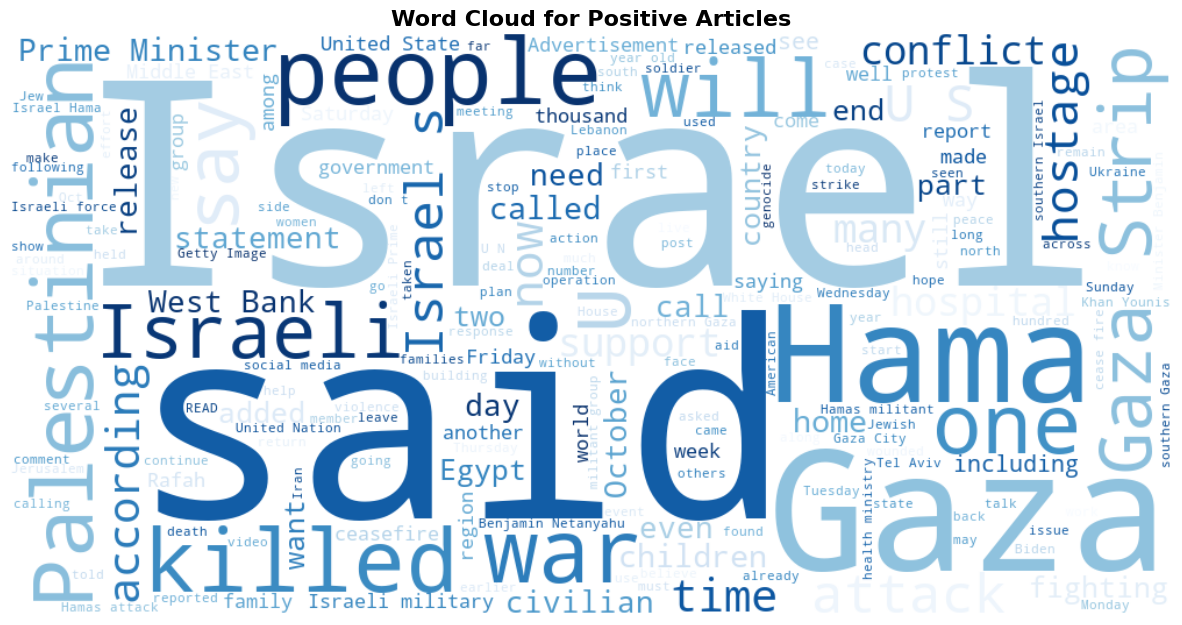

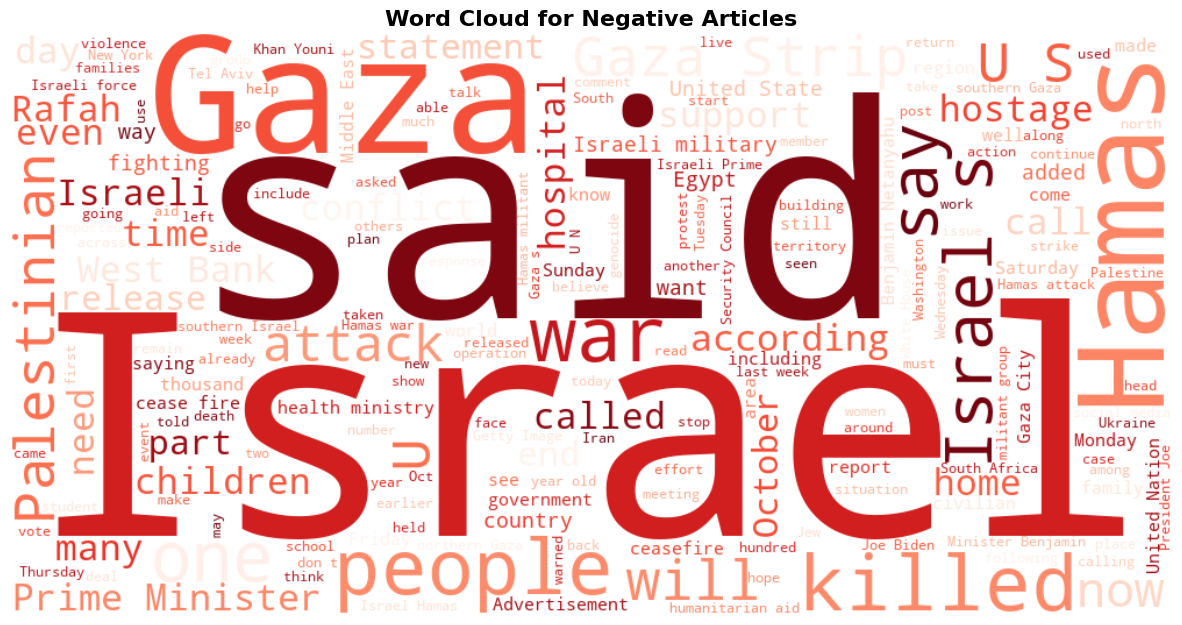

In [278]:
# Load your data
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

# Define sentiment categories
positive_sentiments = ["Positive (POS)", "Slightly Positive (SPOS)"]
negative_sentiments = ["Negative (NEG)", "Extremely Negative (ENEG)", "Slightly Negative (SNEG)"]

# Filter the data for positive and negative articles
df_positive = df[df['label'].isin(positive_sentiments)]
df_negative = df[df['label'].isin(negative_sentiments)]

# Combine all positive and negative articles into one string for each
positive_text = " ".join(df_positive['MainText'].dropna())
negative_text = " ".join(df_negative['MainText'].dropna())
positive_text = positive_text.replace("Hama ", "Hamas ").replace("Hamas.", "Hamas ")
negative_text = negative_text.replace("Hama ", "Hamas ").replace("Hamas.", "Hamas ")

# Create a word cloud for positive articles with custom colors and fonts
wordcloud_pos = WordCloud(
    width=1000, 
    height=500, 
    background_color="white", 
    colormap='Blues',  # Custom color scheme for positive articles
    contour_color='steelblue',
    contour_width=1.5
).generate(positive_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Articles", fontsize=16, fontweight='bold')
plt.show()

# Create a word cloud for negative articles with custom colors and fonts
wordcloud_neg = WordCloud(
    width=1000, 
    height=500, 
    background_color="white", 
    colormap='Reds',  # Custom color scheme for negative articles
    contour_color='darkred',
    contour_width=1.5
).generate(negative_text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Articles", fontsize=16, fontweight='bold')
plt.show()

# Bar chart for top words (using CountVectorizer)
def plot_top_words(text_data, sentiment_label):
    vectorizer = CountVectorizer(stop_words='english', max_features=25)
    word_counts = vectorizer.fit_transform(text_data).toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    
    word_df = pd.DataFrame({'word': words, 'count': word_counts})
    word_df = word_df.sort_values(by='count', ascending=False)

    # Use Plotly Express with custom color palette and layout settings
    fig_bar_chart = px.bar(
        word_df,
        x='word',
        y='count',
        title=f'Top Words in {sentiment_label} Articles',
        labels={'word': 'Word', 'count': 'Count'},
        color='count',
        color_continuous_scale='Viridis'  # Custom color scale
    )
    
    # fig_bar_chart.update_traces(marker_line_width=1.5, marker_line_color='black')
    
    fig_bar_chart.update_layout(
        xaxis_tickangle=-45, 
        title_font_size=20,
        title_x=0.5,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
        font=dict(family="Arial", size=14)
    )
    
    fig_bar_chart.show()

# Bar chart for positive articles
plot_top_words(df_positive['MainText'].dropna(), 'Positive')

# Bar chart for negative articles
plot_top_words(df_negative['MainText'].dropna(), 'Negative')

In [279]:
# Load your data
df = pd.read_csv('./preprocessed_data/articles_with_predictions_3.csv')

# Define sentiment categories
positive_sentiments = ["Positive (POS)", "Slightly Positive (SPOS)"]
negative_sentiments = ["Negative (NEG)", "Extremely Negative (ENEG)", "Slightly Negative (SNEG)"]

# Filter the data for positive and negative articles
df_positive = df[df['label'].isin(positive_sentiments)]
df_negative = df[df['label'].isin(negative_sentiments)]

# Combine positive and negative texts into a single list
texts = df_positive['MainText'].dropna().tolist() + df_negative['MainText'].dropna().tolist()

# Create labels (0 for positive, 1 for negative)
labels = [0] * len(df_positive) + [1] * len(df_negative)

# Compute TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(texts)

# Convert to DataFrame for easier handling
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# Split back into positive and negative
tfidf_positive = tfidf_df.iloc[:len(df_positive)]
tfidf_negative = tfidf_df.iloc[len(df_positive):]

# Calculate the average TF-IDF score for each word in both positive and negative categories
avg_tfidf_positive = tfidf_positive.mean(axis=0)
avg_tfidf_negative = tfidf_negative.mean(axis=0)

# Identify words that are significantly different between the two categories
tfidf_difference = avg_tfidf_positive - avg_tfidf_negative

# Sort by absolute difference and get the top 20 differentiating words
top_words = tfidf_difference.abs().sort_values(ascending=False).head(20)

significant_words_df = pd.DataFrame({
    'word': top_words.index,
    'difference': top_words.values,
    'category': ['Positive' if tfidf_difference[word] > 0 else 'Negative' for word in top_words.index]
})

print(significant_words_df.sort_values('category'))

            word  difference  category
0            aid    0.006897  Negative
17          city    0.002596  Negative
16  humanitarian    0.002696  Negative
15          2024    0.002847  Negative
13          food    0.003039  Negative
12          gaza    0.003095  Negative
10        famine    0.003295  Negative
19         march    0.002516  Negative
6      ceasefire    0.003611  Negative
3        ramadan    0.004385  Negative
1          rafah    0.006627  Negative
7          unrwa    0.003550  Negative
8         jewish    0.003522  Positive
18       israeli    0.002552  Positive
11      released    0.003262  Positive
5       saturday    0.003828  Positive
4         israel    0.004166  Positive
14        attack    0.002967  Positive
2          hamas    0.005083  Positive
9       israelis    0.003359  Positive


In [280]:
positive_words = significant_words_df[significant_words_df['category'] == 'Positive']
negative_words = significant_words_df[significant_words_df['category'] == 'Negative']

def plot_sentiment_words(words_df, sentiment, color_scale):
    fig = px.bar(
        words_df,
        x='word',
        y='difference',
        title=f'Words More Associated with {sentiment} Sentiment',
        labels={'word': 'Word', 'difference': 'TF-IDF Difference'},
        color='difference',
        color_continuous_scale=color_scale
    )
    fig.update_layout(
        xaxis_tickangle=-45,
        title_font_size=20,
        xaxis=dict(
            tickfont=dict(size=16)
        ),
        plot_bgcolor='rgba(0,0,0,0)'
    )
    return fig

fig_positive = plot_sentiment_words(positive_words, 'Positive', 'Blues')
fig_negative = plot_sentiment_words(negative_words, 'Negative', 'Reds')

fig_positive.show()
fig_negative.show()

fig_positive.write_html('./plots_html/words_associated_with_positive_sentiment_tfidf.html')
fig_negative.write_html('./plots_html/words_associated_with_negative_sentiment_tfidf.html')